# How to select an objective function using information theory

 [![GitHub tag (latest by date)](https://img.shields.io/github/v/tag/hytest-org/workflow-hodson-2022-objective-benchmark)](https://github.com)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hytest-org/workflow-hodson-2022-objective-benchmark/blob/main/01-objective-benchmark-demo.ipynb)

## Abstract
Science tests competing theories or models by evaluating the similarity of their predictions against observational experience. 
Thus, how we measure similarity fundamentally determines what we learn.
In machine learning and scientific modeling, similarity metrics are used as objective functions.
A classic example being mean squared error, which is the optimal measure of similarity when errors are normally distributed and independent and identically distributed (iid). 
In many cases, however, the error distribution is neither normal nor iid, so it is left to the scientist to determine an appropriate objective.
Here, we review how information theory can guide that selection, then demonstrate the approach with a simple hydrologic model.

## Introduction
Science seeks to create useful representations of reality in the form of hypotheses, models, or theories.
What sets science apart from other pursuits is that it rigorously tests those representations against observational experience,
favoring those that best fit the evidence.
An analogous process occurs when calibrating a numerical model or evaluating among competing models.
To select the ``best'' model, experiment by varying the model while keeping the test data and objective fixed.
If mean squared error (MSE) is the objective, compute the MSE between the test data and the model predictions, then select the model with the lowest MSE.
But why choose MSE and not another objective function?
The answer: MSE is the optimal measure when errors are normally distributed and iid.
But for many problems, the true error distribution is complex or unknown.
Rather than simply assuming some de facto objective function, 
compare them against the evidence.
This paper demonstrates how.

To select the best objective, the experiment is essentially the same except the objective is varied while the model and data are held fixed.
Now, select the objective indicating the greatest similarity between data and model.
Different objective functions have different scales, so they are normalized
such that each integrates to one, thereby representing them as probability distributions.
The normalized form of MSE is the normal distribution, for example (Hodson, 2022).
When used to evaluate model fit, the probability distribution is called a likelihood function
and its output the likelihood.
So, to select among objectives, compare their likelihoods, and favor the most likely.
Taking the natural logarithm of the likelihood, denoted as $\ell$,
does not change the models ranks
but simplifies the math by converting products to sums:
likelihoods multiply, so log likelihoods add.


So, to benchmark objectives, compare their log likelihoods.
The maximum likelihood estimators for the log likelihoods of several objectives are implemented below.

In [1]:
# compute likelihood
import numpy as np
from scipy.stats import pearsonr
import scipy.stats


def normal_ll(y, y_hat, transform=None, gradient=1):
    '''Log likelihood for the normal distribution with change of variable
    
    The normal distribution is the formal likelihood for the mean squared error (MSE).
    

    Parameters
    ----------
    y : array_like
        Observations.
    y_hat : array_like
        Predictions.
    transform : function
        Change of variable transformation.
    gradient : function
        Gradient of the transform function.
        
    Proof
    -----
    https://www.statlect.com/probability-distributions/normal-distribution
    '''
    if transform is not None:
        y = transform(y)
        y_hat = transform(y_hat)
        
    e = y - y_hat
    n = len(e)
    sigma = e.std()
    log_gradient = np.sum(np.log(np.abs(gradient)))
    ll = -n * np.log(sigma) - n/2*np.log(2*np.pi) - 1/(2*sigma**2) * (e**2).sum() + log_gradient
    return ll


def laplace_ll(y, y_hat, transform=None, gradient=1):
    '''Log likelihood for Laplace distribution with change of variable
    
    The laplace distribution is the formal likelihood for the mean absolute
    error (MAE).
    
    Parameters
    ----------
    y : array_like
        Observations.
    y_hat : array_like
        Predictions.
    transform : function
        Change of variable transformation.
    gradient : function
        Gradient of the transform function.
    '''
    if transform is not None:
        y = transform(y)
        y_hat = transform(y_hat)
        
    e = (y - y_hat).abs()
    n = len(e)
    b = e.mean()
    log_gradient = np.sum(np.log(np.abs(gradient)))
    ll = -n * np.log(2*b) - 1/b * e.sum() + log_gradient
    return ll.sum()
                                   

def msre_ll(y, y_hat):
    '''Log likelihood for mean squared square-root error
    
    Parameters
    ----------
    y : array_like
    y_hat : array_like
    '''
    return normal_ll(y, y_hat, transform=lambda x: np.sqrt(x), gradient=-1/(2*np.sqrt(y)))


def mare_ll(y, y_hat):
    '''Log likelihood for mean absolute square-root error
    
    Parameters
    ----------
    y : array_like
    y_hat : array_like
    '''
    return laplace_ll(y, y_hat, transform=lambda x: np.sqrt(x), gradient=-1/(2*np.sqrt(y)))


def lognormal_ll(y, y_hat):
    '''Lognormal log likelihood
    
    The lognormal distribution is the formal likelihood for the mean squared
    log error (MSLE).
    
    Parameters
    ----------
    y : array_like
    y_hat : array_like
    '''
    return normal_ll(y, y_hat, transform=lambda x: np.log(x), gradient=1/y)


def mspe_ll(y, y_hat):
    '''Log likelhood for mean squared percentage error
    
    Parameters
    ----------
    y : array_like
    y_hat : array_like
    
    '''
    return normal_ll(y, y_hat, transform=lambda x: x/y, gradient=-1/(y**2)) 


def nse_ll(y, y_hat, group='gage_id'):
    '''Log likelihood for normalized squared error (NSE)
    
    NSE is equivalent to the Nash–Sutcliffe model efficiency coefficient.
    
    Parameters
    ----------
    y : array_like
    y_hat : array_like
    '''
    sigma_o = y.groupby('gage_id').transform(lambda x: x.std())
    return normal_ll(y, y_hat, transform=lambda x: x/sigma_o, gradient=1/sigma_o)


def loglaplace_ll(y, y_hat):
    '''Log likelihood for log Laplace distribution
    
    Parameters
    ----------
    y : array_like
    y_hat : array_like
    '''
    return laplace_ll(y, y_hat, transform=lambda x: np.log(x), gradient=1/y)


def uniform_ll(y, y_hat):
    '''Log likelihood for uniform distribution.
    
    The uniform log likelihood minimizes the maximum error.
    
    Parameters
    ----------
    y : array_like
    y_hat : array_like
    '''
    e = np.abs(y - y_hat)
    n = len(e)
    #ll = -n * np.log(e.max()-e.min()) # standard formulation
    ll = -n * np.log(e.max() - 0)
    return ll


def bernoulli_ll(y, y_hat, groupby=None):
    '''TODO and use within zi_ll
    
    Parameters
    ----------
    y : array_like
    y_hat : array_like
    '''
    pass



def zi_ll(y, y_hat, ll=normal_ll, threshold=0.01, groupby=None):
    ''' Zero-inflated log likelihood.
    
     Parameters
    ----------
    y : array_like
    y_hat : array_like
    ll : function
        Zero-inflated log likelihood 
    threshold : float
        Value below which is treated as zero
    groupby : string
        Optional groupby term (testing)
    '''
    y_o = y <= threshold
    y_hat_o = y_hat <= threshold
    
    if groupby is None:
        n1 = (y_o & y_hat_o).sum() # correct zero-flow prediction
        n2 = (y_o ^ y_hat_o).sum() # incorrect zero-flow prediction 
    else:
        n1 = (y_o & y_hat_o).groupby(groupby).sum() # correct zero-flow prediction
        n2 = (y_o ^ y_hat_o).groupby(groupby).sum() # incorrect zero-flow prediction

    n3 = (~y_o & ~y_hat_o) # correct flow predictions
    
    # fraction of correctly predicted zero flows
    rho = np.where( (n1+n2) == 0, 0, n1 / (n1 + n2))
    n_rho = 1-rho
    
    # n1 * np.log(rho) + n2 * np.log(1-rho)
    ll_zero = n1[rho!=0] * np.log(rho[rho!=0]) + n2[n_rho!=0]* np.log(n_rho[n_rho!=0])
    
    return ll_zero.sum() + ll(y[n3], y_hat[n3])


def zilognormal_ll(y, y_hat):
    '''Log likelihood for zero-inflated lognormal.
    
    Parameters
    ----------
    y : array_like
    y_hat : array_like
    '''
       
    return zi_ll(y, y_hat, ll=lognormal_ll, threshold=0.01)


def ziloglaplace_ll(y, y_hat):
    '''Log likelihood for zero-inflated laplace.
    
    Parameters
    ----------
    y : array_like
    y_hat : array_like
    '''
    return zi_ll(y, y_hat, ll=loglaplace_ll, threshold=0.01)


In [28]:
import pandas as pd
import numpy as np

# read local copy
df = pd.read_parquet('gages2_nndar.parquet')
df[df < 0.01] = 0.01

sigma_o = df['obs'].groupby('gage_id').transform(lambda x: x.std())

In [32]:
def nse_ll(y, y_hat, sigma_o=None, group='gage_id'):
    '''Log likelihood for normalized squared error (NSE)
    
    NSE is equivalent to the Nash–Sutcliffe model efficiency coefficient.
    
    Parameters
    ----------
    y : array_like
    y_hat : array_like
    '''
    if sigma_o is None:
        sigma_o = y.groupby('gage_id').transform(lambda x: x.std(ddof=0))
        
    return normal_ll(y, y_hat, transform=lambda x: x/sigma_o, gradient=1/sigma_o)

def nse_g(y, y_hat):
    return nse_ll(y, y_hat, sigma_o = sigma_o)

In [40]:
count = df.groupby('gage_id').count()['obs']

In [ ]:
# step 1: create a table of objective functions
objectives = {
    'U' : {'name':'uniformly distributed error', 'f':uniform_ll},
    'MSE' : {'name':'mean squared error', 'f':normal_ll},
    'NSE' : {'name':'normalized squared error', 'f':nse_g},
    'MAE' : {'name': 'mean absolute error', 'f':laplace_ll},
    'MSPE' : {'name': 'mean squared percent error', 'f':mspe_ll},
    'MSLE' : {'name':'mean squared log error*', 'f':lognormal_ll},
    'MALE' : {'name':'mean absolute log error*', 'f':loglaplace_ll},
    'ZMSLE' : {'name':'zero-inflated MSLE', 'f':zilognormal_ll},
    'ZMALE' : {'name':'zero-inflated MALE', 'f':ziloglaplace_ll},
    'MARE' : {'name':'mean absolute square root error', 'f':mare_ll},
}

obj_df = pd.DataFrame.from_dict(objectives, orient='index')

# step 2: compute the information in each objective function
results = []
for index, row in obj_df.iterrows():
    # nats is the negative log likelihood or the info in the error
    #results.append(- row.f(df.obs, df.NNDAR)/count/np.log(2) )
    results.append(- df.groupby('gage_id').apply(lambda x: row.f(x['obs'], x['NNDAR']))/count/np.log(2))

In [ ]:
results[0]

In [ ]:
pd.DataFrame(results, columns=obj_df.index)

In [4]:
#fix
count = df.groupby('gage_id').count()['obs']
zmale = -df.groupby('gage_id').apply(lambda x: ziloglaplace_ll(x['obs'], x['NNDAR']))/count/np.log(2)
zmsle = -df.groupby('gage_id').apply(lambda x: zilognormal_ll(x['obs'], x['NNDAR']))/count/np.log(2)
mse = -df.groupby('gage_id').apply(lambda x: normal_ll(x['obs'], x['NNDAR']))/count/np.log(2)

/tmp/ipykernel_740/340847794.py:198: RuntimeWarning: invalid value encountered in scalar divide
  rho = np.where( (n1+n2) == 0, 0, n1 / (n1 + n2))
/tmp/ipykernel_740/340847794.py:198: RuntimeWarning: invalid value encountered in scalar divide
  rho = np.where( (n1+n2) == 0, 0, n1 / (n1 + n2))


In [23]:
# revise this plot to be a heat map
# nan any massive values
import seaborn

In [5]:
# filter one estimate that blew up
i = zmsle.values < 20000

zmale = zmale[i]
zmsle = zmsle[i]
mse = mse[i]


In [6]:
import matplotlib.pyplot as plt
from matplotlib import rc

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


#plt.rcParams['font.family'] = 'Serif'

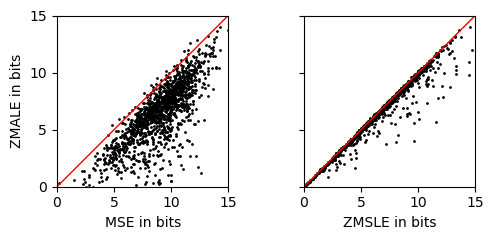

In [20]:


fig, ax = plt.subplots(1,2 , sharex=True, sharey=True, figsize=(5.512,2.5))
#fig, ax = plt.subplots(1,2 , sharex=True, sharey=True, figsize=(3.54,2.5))

#mse_rank = mse.argsort()/len(mse) * 100
#zmsle_rank = zmsle.argsort()/len(zmsle) * 100
#zmale_rank = zmale.argsort()/len(zmale) * 100
#ax[0].scatter(mse_rank, zmale_rank, color='k', s=1)
#ax[1].scatter(zmsle_rank, zmale_rank, color='k', s=1)

ax[0].scatter(mse.values, zmale.values, color='k', s=1)
ax[1].scatter(zmsle.values, zmale.values, color='k', s=1)

for i in [0,1]:
    ax[i].set_aspect('equal')
    ax[i].set_ylim([0,15])
    ax[i].set_xlim([0,15])
    ax[i].axline((0,0), (15,15), color='red', linewidth=1)
    ax[i].set_yticks([0,5,10,15])
    ax[i].set_xticks([0,5,10,15])



ax[0].set_ylabel('ZMALE in bits')# fontname="Arial")
ax[0].set_xlabel('MSE in bits')
ax[1].set_xlabel('ZMSLE in bits')

#fig.subplots_adjust(hspace=0, wspace=0)
fig.tight_layout()
fig.savefig('figure2.pdf')

In [25]:
d


,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
0,-0.318854,-1.602981,-1.535218,-0.570401,-0.216728,0.254874,-0.149450,2.010783,-0.096784,0.422202,...,-0.951219,0.832973,-1.000208,0.343463,1.546030,0.690081,-2.045853,0.334467,-0.641459,-0.222497
1,-1.230374,0.205848,0.821371,-0.493780,-1.408794,-1.216324,1.734299,-0.206790,-0.733189,0.774163,...,-0.148826,-0.606270,-1.185801,0.455504,-0.837645,-0.146961,-0.682350,1.487670,-1.094711,-1.654707
2,-0.023842,-0.363738,-0.482943,0.739577,0.611252,0.491802,1.792924,-0.683737,1.054113,-0.615562,...,-1.120717,0.991136,1.630796,-1.900090,0.062316,0.479998,0.379609,-1.512245,0.289020,0.095524
3,-0.292821,0.856582,0.933473,-0.421045,1.590430,-1.063801,2.104884,-1.090494,1.484521,-1.089229,...,0.230258,0.195235,0.535839,0.684299,2.821279,0.916504,0.150722,0.017747,0.006885,0.329035
4,-0.587376,1.751572,0.308274,-0.894283,-0.769156,0.869197,0.371381,-0.628362,-0.922477,-0.903391,...,1.519031,0.749896,-2.269087,-0.760599,-0.955502,0.923951,0.315157,1.340910,0.678992,0.594258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-1.036298,-1.177101,-2.472118,-0.370044,0.108184,-0.753487,-0.331042,2.203373,-0.319100,0.428793,...,-0.087225,0.190644,-0.506678,-0.442679,-1.186259,0.743655,-1.842236,0.702369,-0.726212,-0.792110
96,-0.681074,2.203923,1.555724,-0.808559,-1.415792,0.586590,0.393986,0.455118,-0.050184,1.298277,...,-0.607768,0.051741,-1.183910,0.830444,0.911260,-1.470621,-0.450259,-1.146024,-0.548446,-0.016534
97,0.616011,0.162773,-0.425326,2.040243,0.339979,0.489751,1.030780,1.061831,-0.040148,-1.406366,...,-1.248445,-0.530126,-0.045328,1.314023,-0.203060,0.767502,2.055105,-0.131154,-1.185281,-0.208766
98,-1.268506,-0.815121,-1.670919,-1.103345,-1.348075,0.157345,0.249971,0.581991,0.115223,-0.898088,...,0.227623,-0.147131,0.692395,-1.308567,-1.197288,-1.348862,-1.612158,0.968366,-0.936233,-0.733935


<Axes: >

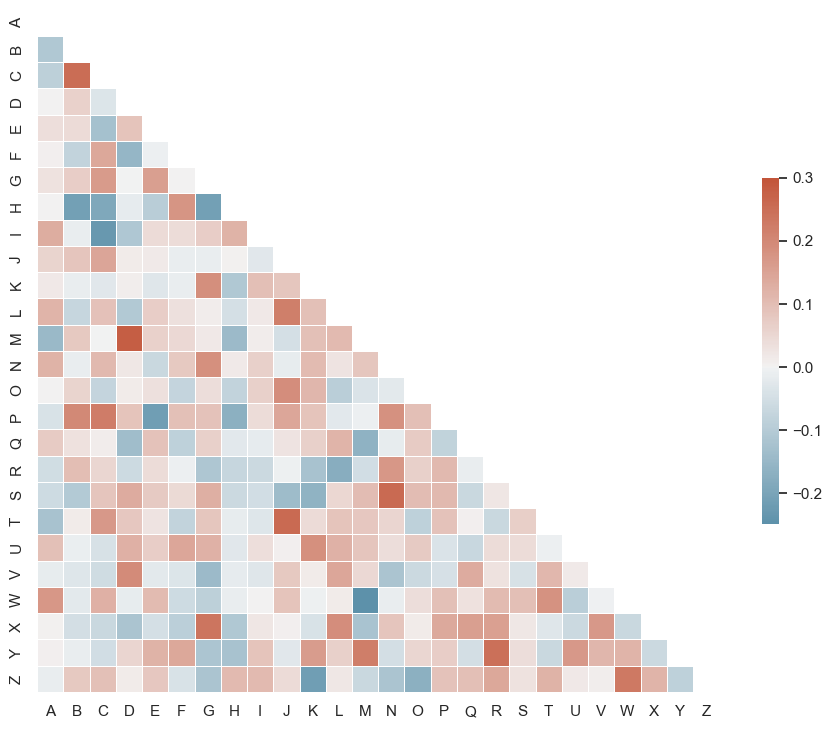

In [24]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

mse.max()

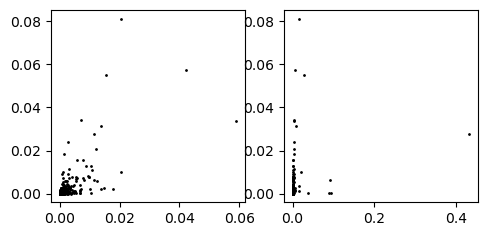

In [15]:


fig, ax = plt.subplots(1,2, figsize=(5.512,2.5))

#mse_rank = mse.argsort()/len(mse) * 100
#zmsle_rank = zmsle.argsort()/len(zmsle) * 100
#zmale_rank = zmale.argsort()/len(zmale) * 100
#ax[0].scatter(mse_rank, zmale_rank, color='k', s=1)
#ax[1].scatter(zmsle_rank, zmale_rank, color='k', s=1)
mse_weights = compute_weights(mse)
zmale_weights = compute_weights(zmale)
zmsle_weights = compute_weights(zmsle)

ax[0].scatter(mse_weights, zmale_weights, color='k', s=1)
ax[1].scatter(zmsle_weights, zmale_weights, color='k', s=1)

#for i in [0,1]:
    #ax[i].set_aspect('equal')
    #ax[i].set_ylim([0,15])
    #ax[i].set_xlim([0,15])
    #ax[i].axline((0,0), (15,15), color='red', linewidth=1)
    #ax[i].set_yticks([0,5,10,15])
    #ax[i].set_xticks([0,5,10,15])



#ax[0].set_ylabel('$\mathregular{ZMALE}_i$ in bits')
#ax[0].set_xlabel('$\mathregular{MSE}_i$ in bits')
#ax[1].set_xlabel('$\mathregular{ZMSLE}_i$ in bits')

# scratch

In [35]:
# step 1: create a table of objective functions
objectives = {
    'U' : {'name':'uniformly distributed error', 'f':uniform_ll},
    'MSE' : {'name':'mean squared error', 'f':normal_ll},
    'NSE' : {'name':'normalized squared error', 'f':nse_ll},
    'MAE' : {'name': 'mean absolute error', 'f':laplace_ll},
    'MSPE' : {'name': 'mean squared percent error', 'f':mspe_ll},
    'MSLE' : {'name':'mean squared log error*', 'f':lognormal_ll},
    'MALE' : {'name':'mean absolute log error*', 'f':loglaplace_ll},
    'ZMSLE' : {'name':'zero-inflated MSLE', 'f':zilognormal_ll},
    'ZMALE' : {'name':'zero-inflated MALE', 'f':ziloglaplace_ll},
    'MARE' : {'name':'mean absolute square root error', 'f':mare_ll},
}

obj_df = pd.DataFrame.from_dict(objectives, orient='index')

# step 2: compute the information in each objective function
for index, row in obj_df.iterrows():
    # nats is the negative log likelihood or the info in the error
    obj_df.loc[index, 'bits'] = - row.f(df.obs, df.NNDAR)/len(df)/np.log(2)

# step 3: compute weights
obj_df['weight'] = compute_weights(-obj_df.bits, base=2)

# step 4: format output table

table = obj_df[['name','bits','weight']].sort_values('weight').round(2)#.rename(columns=names)

table['rank'] = len(table) - np.argsort(table['weight'])

In [1]:
obj_df

NameError: name 'obj_df' is not defined

Results are shown in the table below.
In the experiment, the data and model were fixed;
therefore, so was the information in the error.
All that changed was how we measured it.
Relative to ZMALE, the excess bits in the other objective functions are noise.
So, MSE measures at least 40 percent noise,
and NSE at least 38 percent.
Consider stochastic gradient descent, where noisier gradients require more iterations to reach the solution.
In that case, each iteration completes faster, so the solution may be reached quicker overall.
A poorly chosen objective incurs a similar penalty but potentially without benefit.
In general, noisier objectives convey less information and so require more iterations during calibration,
more data to reach the solution,
and produce models that require more storage space
(better model, better data compression).

In [8]:
#print(table.to_latex())
table

,name,bits,weight,rank
MSPE,mean squared percent error,23.54,0.00,10
U,uniformly distributed error,18.17,0.00,9
MSE,mean squared error,11.62,0.01,8
NSE,normalized squared error,11.20,0.01,7
MAE,mean absolute error,9.49,0.04,6
MSLE,mean squared log error*,7.47,0.15,5
MARE,mean absolute square root error,7.34,0.17,4
ZMSLE,zero-inflated MSLE,7.18,0.19,3
MALE,mean absolute log error*,7.04,0.21,2
ZMALE,zero-inflated MALE,6.95,0.22,1


## Conclusions
Despite their ubiquitous use as a basis for learning,
objective functions are rarely benchmarked, except by Bayesians.
We do not advocate for one over another
---the choice varies from problem to problem---
only that benchmarking objectives is good practice that will yield better models,
both in terms of their accuracy and in how they are evaluated:
objective functions quantify model performance,
as well as uncertainty and potential compression.
Perhaps given this simple demonstration, more scientists will test different measures of similarity by benchmarking their objectives.
After all, how well machines---and scientists---learn and think depends a lot on how well they measure similarity.

In [7]:
# compute noise in MSE and NSE
mse_bits = table.loc['MSE', 'bits']
nse_bits = table.loc['NSE', 'bits']
zmale_bits = table.loc['ZMALE', 'bits']
mse_noise = round(100*(mse_bits - zmale_bits) / mse_bits)
nse_noise = round(100*(nse_bits - zmale_bits) / nse_bits)
print(f'MSE is at least {mse_noise} percent noise and NSE at least {nse_noise} percent.')

MSE is at least 40 percent noise and NSE at least 38 percent.


## Bootstrap

In [23]:
n = 1000
sites = pd.Series(df.index.get_level_values(0).unique()) # 1385 sites

In [34]:
#obj_df

,name,f
U,uniformly distributed error,<function uniform_ll at 0x7f7b13b0a5c0>
MSE,mean squared error,<function normal_ll at 0x7f7b5aef4ea0>
NSE,normalized squared error,<function nse_ll at 0x7f7b13b0a480>
MAE,mean absolute error,<function laplace_ll at 0x7f7b58100180>
MSPE,mean squared percent error,<function mspe_ll at 0x7f7b13b0a3e0>
MSLE,mean squared log error*,<function lognormal_ll at 0x7f7b13b0a340>
MALE,mean absolute log error*,<function loglaplace_ll at 0x7f7b13b0a520>
ZMSLE,zero-inflated MSLE,<function zilognormal_ll at 0x7f7b13b0a700>
ZMALE,zero-inflated MALE,<function ziloglaplace_ll at 0x7f7b13b0a840>
MARE,mean absolute square root error,<function mare_ll at 0x7f7b13b0a160>


In [ ]:
n = 1000
boot_array = np.zeros((n, obj_df.f.shape[0]))

for i in range(0,n):
    temp_df = df.sample(df.shape[0], replace=True)

    for j,f in enumerate(obj_df.f):
        boot_array[i,j]= f(temp_df.obs, temp_df.NNDAR)#/len(lemp_df)/np.log(2)


boot_df = pd.DataFrame(boot_array)
boot_df.to_csv('ell_boot.csv')

## Data availability
The streamflow data are from Russell et al. (2020) and are available at https://doi.org/10.5066/P9XT4WSP.
This demonstration notebook is available at at https://code.usgs.gov/wma/hytest/workflow-hodson-2022-objective-benchmark. 


## References 
Burnham, K.P. and Anderson, D.R. (2002). Model selection and multimodel inference: A Practical Information-Theoretic Approach. 2nd Edition, Springer-Verlag, New York.

Hodson, T.O. (2022). Root-mean-square error (RMSE) or mean absolute error (MAE): when to use them or not, Geosci. Model Dev., 15, 5481–5487. https://doi.org/10.5194/gmd-15-5481-2022

Russell, A.M., Over, T.M., and Farmer, W.H. (2020). Cross-validation results for five statistical methods of daily streamflow estimation at 1,385 reference streamgages in the conterminous United States, Water Years 1981-2017: U.S. Geological Survey data release. https://doi.org/10.5066/P9XT4WSP

In [14]:
df

obs    NNDAR
gage_id         date                      
01013500        1980-10-01  509.0   649.55
                1980-10-02  518.0   618.91
                1980-10-03  516.0   618.91
                1980-10-04  620.0   796.61
                1980-10-05  759.0  1397.14
...                           ...      ...
402114105350101 2017-09-26   23.4    23.32
                2017-09-27   22.1    22.79
                2017-09-28   23.8    26.72
                2017-09-29   28.4    26.99
                2017-09-30   25.5    25.15

[14067063 rows x 2 columns]

In [10]:
# Scratch

In [191]:
def rss(y, y_hat):
    return ((y - y_hat)**2).sum()

def mse(y, y_hat):
    return ((y - y_hat)**2).mean()

In [ ]:
n = 50000
data = np.random.normal(0, 1, (n, n))

In [ ]:
mse_x = np.apply_along_axis(lambda x: mse(x,0), 1, data)

In [ ]:
rss_x = np.apply_along_axis(lambda x: rss(x,0), 1, data)

In [ ]:
l2_x = np.apply_along_axis(lambda x: normal_ll(x,0), 1, data)

In [ ]:
def aic(x):
    return -2 * x + 2

def aic_ls(x):
    return n *np.log(x/n) + 2


def w(x, aic):
    x = aic(x)
    return np.exp(-(x-x.min()))/np.exp(-(x-x.min())).sum()

def w(x, aic):
    x = aic(x)
    return np.exp(-(x-x.min()))/np.exp(-(x-x.min())).sum()

In [ ]:
(w(l2_x, aic).argsort() == w(rss_x, aic_ls).argsort()).sum()/n

In [265]:
w(mse_x, aic_ls)

array([1.78879838e-09, 2.27638566e-09, 4.09610296e-21, 8.75915704e-16,
       4.15866904e-18, 1.72064257e-16, 6.84863529e-19, 1.14887121e-17,
       2.81969525e-19, 1.04505571e-24, 2.98667623e-23, 8.32321453e-13,
       1.33639345e-24, 9.43731218e-25, 4.02634562e-33, 4.34670942e-07,
       5.31512137e-22, 2.47058502e-17, 5.99007642e-14, 7.41581295e-20,
       1.63478239e-25, 6.46133115e-24, 2.27141881e-17, 1.32352634e-23,
       4.08497863e-13, 1.67604186e-14, 1.88107518e-27, 2.44168686e-22,
       3.23203594e-19, 1.80761831e-21, 1.51455626e-22, 2.22778413e-30,
       2.89776612e-25, 1.07458782e-26, 5.64952974e-20, 1.42312121e-29,
       1.37866506e-27, 7.85909846e-33, 1.13642723e-09, 7.63088984e-28,
       5.76434381e-25, 1.00521398e-27, 5.61560030e-22, 1.02381297e-17,
       4.25151056e-09, 1.29509513e-25, 1.47690700e-30, 9.99996869e-01,
       2.49010801e-25, 3.37186588e-09, 1.37540204e-21, 5.81642957e-24,
       3.48419009e-21, 9.58823173e-34, 7.18522895e-22, 2.48712335e-19,
      

In [262]:
w(l2_x, aic)

array([9.14915850e-28, 7.19016171e-28, 3.96940463e-16, 1.82429762e-21,
       3.93577388e-19, 9.50631865e-21, 2.28372671e-18, 1.42466594e-19,
       5.80329257e-18, 1.56261664e-12, 5.47924054e-14, 1.96645529e-24,
       1.22471107e-12, 1.55817247e-12, 4.06503609e-04, 3.52924685e-30,
       3.07943683e-15, 6.62403126e-20, 2.73174691e-23, 2.20711868e-17,
       9.99353828e-12, 2.50412908e-13, 7.11552973e-20, 1.23541133e-13,
       3.85478503e-24, 9.57906927e-23, 8.70118150e-10, 6.25214703e-15,
       5.06416240e-18, 9.03442546e-16, 1.08064371e-14, 7.34608869e-07,
       5.57651299e-12, 1.46227846e-10, 2.88591211e-17, 1.14838607e-07,
       1.17821141e-09, 2.07297333e-04, 1.39851856e-27, 2.08170643e-09,
       2.76388860e-12, 1.62826834e-09, 2.91157755e-15, 1.54841354e-19,
       3.70364607e-28, 1.26378505e-11, 1.10800414e-06, 1.63676322e-36,
       6.54764223e-12, 4.82992591e-28, 1.18469444e-15, 2.81322208e-13,
       4.69696433e-16, 1.67272023e-03, 2.25561225e-15, 6.58092797e-18,
      

In [198]:
w(l2_x, aic)

array([2.49141897e-049, 5.13971886e-084, 4.58066551e-080, 1.57957009e-068,
       2.00557177e-044, 8.72548093e-095, 1.59460010e-073, 2.00932902e-086,
       9.82214120e-070, 8.26733838e-056, 1.85093862e-081, 2.32880391e-035,
       6.54505466e-025, 2.98397834e-021, 8.56094405e-078, 7.09355784e-084,
       1.52039417e-062, 3.95910923e-072, 1.30755750e-089, 3.89126352e-071,
       1.82559129e-059, 3.03505362e-076, 8.24353624e-067, 5.48834134e-070,
       8.25707724e-088, 6.27055643e-042, 1.16472408e-063, 6.75738952e-052,
       3.16755753e-095, 1.05529573e-082, 6.74354440e-076, 1.81604020e-027,
       3.00162224e-064, 3.52134811e-057, 7.33463598e-025, 1.84228931e-067,
       2.50422780e-076, 2.30930268e-063, 2.04417407e-077, 3.03542590e-064,
       4.24910637e-033, 8.35311284e-066, 3.53519474e-056, 1.33770137e-070,
       2.17615459e-041, 1.01630989e-071, 9.99765288e-001, 9.70378088e-057,
       1.65708235e-064, 8.20919375e-070, 1.74397424e-078, 1.25689465e-056,
       8.80338462e-054, 2

In [159]:
np.exp(l2_x-l2_x.min())/np.exp(l2_x.min())

array([2.64365680e+25, 7.11938202e+27, 7.31011090e+27, 8.37093149e+24,
       5.67551963e+24, 4.94616766e+24, 1.53345409e+23, 1.40412259e+24,
       1.85016127e+26, 3.77886779e+23, 2.35766905e+23, 3.22820515e+25,
       1.63318505e+23, 9.24222280e+24, 1.96391861e+27, 3.18512642e+24,
       7.09746790e+24, 3.29233505e+27, 3.48186209e+26, 4.42971538e+25,
       2.70268094e+28, 1.05349994e+27, 9.84467493e+23, 3.02716284e+26,
       4.34155922e+24, 7.95552016e+24, 9.76032058e+21, 2.12517192e+26,
       1.30343901e+27, 7.16242664e+24])

In [74]:
l2_x-l2_x.min()

array([22.51608453, 14.09236515, 28.31383373, 32.92991663, 27.15465924,
       17.66719084,  5.65097713, 13.02897638, 18.04210945, 25.84807844,
       17.38634323, 41.15833121, 26.09072319, 24.41736843, 22.16526915,
       18.39734021, 21.89005803, 12.29929315, 21.48724801, 25.56161675,
       17.5560736 , 20.19272128, 26.31759136, 25.73086737,  0.        ,
       25.0465841 , 19.68190691, 26.08583563,  7.66115962, 13.25461687,
       14.95460946, 10.61823526, 16.42083129, 18.15553732, 18.85842705,
       16.24769542, 12.13032768, 13.64437488, 21.59496027, 12.65947581,
       23.6016988 , 17.2390534 , 29.64629583, 11.58141018, 19.4651066 ,
       20.85609799, 26.65941541, 35.35240679, 15.69187519, 24.43329941,
       16.64648375, 16.38049176, 34.61361407, 29.78813304, 25.76229291,
       17.24076217, 36.50964971, 27.60008541, 30.38114038, 25.98162442,
       30.65801575, 22.54316032, 22.17690242, 25.67603028, 33.56986769,
        9.69563628, 21.31022904, 17.07192391, 30.46816148, 23.07

In [65]:
l2_x

array([88, 43, 52, 47, 18, 35, 96, 29, 39, 17, 31, 41, 46, 57,  4, 97, 13,
       11, 42, 95, 19, 53, 77, 87, 72, 40, 27, 90, 45, 76, 36, 80, 15,  6,
       74, 22, 12, 50, 86,  0, 59, 30, 38, 99, 37, 85, 83, 61, 81, 33, 21,
        7, 54, 24, 78,  2,  5, 73, 14, 55, 20, 65, 84, 66, 91, 94, 79, 89,
       44, 58, 32, 49,  8,  9, 67, 48, 64, 16,  3, 23, 25, 51, 69, 28, 98,
       62, 70, 92, 60, 82, 63, 56,  1, 26, 68, 34, 71, 93, 10, 75])